In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, Attention
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# load data
test = pd.read_csv('test_secondary_structure_cb513.csv')
train = pd.read_csv('training_secondary_structure_train.csv')
valid = pd.read_csv('validation_secondary_structure_valid.csv')

combined = pd.concat([test, train, valid], ignore_index=True)

combined.to_csv('combined_csv_file.csv', index=False)
train_df, temp_df = train_test_split(combined, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

display(train_df.head())
display(valid_df.head())
display(test_df.head())
print(f"train set: {train_df.shape[0]}")
print(f"valid set: {valid_df.shape[0]}")
print(f"test set: {test_df.shape[0]}")







,seq,sst3,sst8
10590,SEDDGSASPESQEMSYTELPCPSICPLIYAPVCVEDSNQDFYLFVN...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEECCCCEEEECC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEETTSCEEEESS...
6909,SIEWHKFETSEEIISTYLLDDVLYTGVNGAVYTFSNNKLNKTGLTN...,CCEEEECCCCCCCCEEEEECCEEEEECECEEEEEECCEEEEEECCC...,CCEEEECSSCCCCCEEEEETTEEEEECBSEEEEEETTEEEEEECCS...
3541,MKHHHHHHSAGLEVLFQGPDSMYVLQDPIWLLMANTDDSIMMTYQL...,CCCCCCCCCCCCCEEEECCCCCEEEECCHHHHCCCCCHHHHHHCCC...,CCCCCCCCCCCCCEEEECSTTCEEEECCHHHHTSCCCHHHHHHCCC...
167,AACKCDDEGPDIRTAPLTGTVDLGSCNAGWEKCASYYTIIADCCRKKK,CEEECCCCCCCCCCCCEEEEEEECCCCCCEEEEEEEEECCEEEEEECC,CEEECSSCCSCCSSSSEEEEEEESSCCTTEEEEEEEEETTEEEEEECC
1915,GAMAQVPTDPGYFSVLLDVKHFSPEEISVKVVGDHVEVHARHEERP...,CCCCCCCCCCCCEEEEEECCCCCHHHEEEEEECCEEEEEEEEEECC...,CCCCCCCCCSSCEEEEEECTTSCGGGEEEEEETTEEEEEEEEEECS...


,seq,sst3,sst8
8167,GXTDTNLVEXRAIERXXFDYSYHLDXNHPEELAALFVEDCEVSYAP...,CCHHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHCCEEEEEEEEEEC...,CCHHHHHHHHHHHHHHHHHHHHHHHTTCHHHHHTTEEEEEEEEEET...
4955,GPGSDLQSILATMNVPAGPAGGQQVDLASVLTPEIMAPILANADVQ...,CCCCCCCCCCCCCCCCCCCCCCCCCCHHHHCCCHHHHHHHCCHHHH...,CCCCCCCCCCCCCCCCCCCCCCCCCCHHHHSCSGGGHHHHTSHHHH...
11039,REFPPPNPDPKFESKAALLAARGPEELLCFTERLEDLVCFWEEAAS...,CCCCCCCCCHHHHHHHHHHHHHCCCCCEEEECCCCCCEEEEEECCC...,CCCCCCCCCHHHHHHHHHHHHHSCSSCEEEBSSSSCCEEEEEECCC...
3532,GSSGSSGMTATAQQLEYLKNSIKSIQDYPKPGILFRDVTSLLEDPK...,CCCCCCCCCCCHHHHHHHHHHCEEECCCCCCCCCEEECHHHHHCHH...,CCCCCCCCCCCHHHHHHHHHHSEEETTCSSTTCCEEETHHHHHCHH...
567,GPGGAERPTLPIPDLLTTDARNRIQLTIGAGQSTFGGKTATTWGYN...,CCCCCCCCECCCCCEECCCCCCEEEEEEEEEEEEECCEEEEEEEEC...,CCCCCCCCBCCCCCEECCCTTSEEEEEEEEEEEEETTEEEEEEEES...


,seq,sst3,sst8
7283,GXSNIYDSANELSRGLRGLPEYKAVKAAKDAIAADAEASKIFTDYL...,CHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHCHHHHHHHHHHH...,CHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHCHHHHHHHHHHH...
6466,MSSLLDIIYQLRQVPRWDGSFQFEKEDVSQHSFSVIAISHILCELK...,CCCHHHHHHHHHHCECCCCCCCCCCCEHHHHHHHHHHHHHHHHHHH...,CCCHHHHHHHGGGCBSSTTSCCSSCCBHHHHHHHHHHHHHHHHHHH...
1791,MILLEVNNRIIEETLALKFENAAAGNKPEAVEVTFADFDGVLYHIS...,CCCCCCCCHHHHHHHHHHHHHHHHCCCCCCCEEEEEECCCEEEEEE...,CCSCCSSCHHHHHHHHHHHHHHHHTCCCCCCEEEEEETTTEEEEEE...
5099,MTMIIRKYFSGIPTIGVLALTTEEITLLPIFLDKDDVNEVSEVLET...,CCCEEEECECCECCHHHHCEECCCEEEECCCCCHHHHHHHHHHHCC...,CCCEEEECBTTBCCHHHHCEECSSEEEECTTCCHHHHHHHHHHHTC...
8471,MAHHHHHHMGTLEAQTQGPGSMTDLQNWTPRPKPERKIFEGRYVRL...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEECCCEEE...,CCCCCCCCCCCCCCCCCCCCCCCCCTTCCCCCCCCCCCEECSSEEE...


train set: 9088
valid set: 1136
test set: 1137


In [3]:
sst8_to_sst3 = {
    'H': 'H', 'G': 'H', 'I': 'H',
    'E': 'E', 'B': 'E',
    'T': 'C', 'S': 'C', 'C': 'C'
}

def map_sst8_to_sst3(sst8):
    return ''.join([sst8_to_sst3.get(char, 'C') for char in sst8])

train_df['sst3_mapped'] = train_df['sst8'].apply(map_sst8_to_sst3)
valid_df['sst3_mapped'] = valid_df['sst8'].apply(map_sst8_to_sst3)
test_df['sst3_mapped'] = test_df['sst8'].apply(map_sst8_to_sst3)

display(train_df[['sst8', 'sst3_mapped']].head())

,sst8,sst3_mapped
10590,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEETTSCEEEESS...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEECCCCEEEECC...
6909,CCEEEECSSCCCCCEEEEETTEEEEECBSEEEEEETTEEEEEECCS...,CCEEEECCCCCCCCEEEEECCEEEEECECEEEEEECCEEEEEECCC...
3541,CCCCCCCCCCCCCEEEECSTTCEEEECCHHHHTSCCCHHHHHHCCC...,CCCCCCCCCCCCCEEEECCCCCEEEECCHHHHCCCCCHHHHHHCCC...
167,CEEECSSCCSCCSSSSEEEEEEESSCCTTEEEEEEEEETTEEEEEECC,CEEECCCCCCCCCCCCEEEEEEECCCCCCEEEEEEEEECCEEEEEECC
1915,CCCCCCCCCSSCEEEEEECTTSCGGGEEEEEETTEEEEEEEEEECS...,CCCCCCCCCCCCEEEEEECCCCCHHHEEEEEECCEEEEEEEEEECC...


In [4]:
def one_hot_encode_sequences(sequences, max_len=None):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_int = {aa: idx for idx, aa in enumerate(amino_acids)}
    aa_to_int['X'] = len(amino_acids)
    
    integer_encoded = []
    for seq in sequences:
        encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in seq]
        integer_encoded.append(encoded)
    
    if not max_len:
        max_len = max(len(seq) for seq in integer_encoded)
    
    padded_encoded = tf.keras.preprocessing.sequence.pad_sequences(
        integer_encoded, maxlen=max_len, padding='post', truncating='post', value=len(amino_acids)
    )
    
    one_hot_encoded = to_categorical(padded_encoded, num_classes=len(amino_acids)+1)
    
    return one_hot_encoded, max_len


X_train, max_len = one_hot_encode_sequences(train_df['seq'])

X_valid, _ = one_hot_encode_sequences(valid_df['seq'], max_len)

X_test, _ = one_hot_encode_sequences(test_df['seq'], max_len)

display(X_train[0])
display(X_valid[0])
print(f"train one-hot shape: {X_train.shape}")
print(f"valid one-hot shape: {X_valid.shape}")
print(f"test one-hot shape: {X_test.shape}")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

train one-hot shape: (9088, 1632, 21)
valid one-hot shape: (1136, 1632, 21)
test one-hot shape: (1137, 1632, 21)


In [5]:
def one_hot_encode_labels(labels, max_len):
    sec_structs = ['H', 'E', 'C']
    struct_to_int = {s: idx for idx, s in enumerate(sec_structs)}
    
    integer_encoded = []
    for lbl in labels:
        encoded = [struct_to_int.get(s, 2) for s in lbl]  
        integer_encoded.append(encoded)
    
    padded_encoded = tf.keras.preprocessing.sequence.pad_sequences(
        integer_encoded, maxlen=max_len, padding='post', truncating='post', value=2
    )
    
    y = to_categorical(padded_encoded, num_classes=len(sec_structs))
    
    return y


y_train = one_hot_encode_labels(train_df['sst3_mapped'], max_len)

y_valid = one_hot_encode_labels(valid_df['sst3_mapped'], max_len)

y_test = one_hot_encode_labels(test_df['sst3_mapped'], max_len)

display(y_train[0])
display(y_valid[0])
print(f"train label one-hot shape: {y_train.shape}")
print(f"valid label one-hot shape: {y_valid.shape}")
print(f"test label one-hot shape: {y_test.shape}")

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

train label one-hot shape: (9088, 1632, 3)
valid label one-hot shape: (1136, 1632, 3)
test label one-hot shape: (1137, 1632, 3)


In [6]:
y_train.shape

(9088, 1632, 3)

In [7]:
import tensorflow as tf

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs {gpus} are available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using CPU.")

No GPU available. Using CPU.


In [8]:
# build model
input_layer = Input(shape=(max_len, X_train.shape[2]))

# conv layer
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv1)
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(conv2)

# lstm
bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(conv2)

# attention
attention = Attention()([bi_lstm, bi_lstm])

dense = Dense(64, activation='relu')(attention)
dropout = Dropout(0.5)(dense)

output_layer = Dense(3, activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1632, 21)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1632, 64)  │      4,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1632, 128) │     24,704 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1632, 256) │    263,168 │ conv1d_1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1632, 256) │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1632, 64)  │     16,448 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1632, 64)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1632, 3)   │        195 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 308,611 (1.18 MB)

 Trainable params: 308,611 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1372s 5s/step - accuracy: 0.8917 - loss: 0.3036 - precision: 0.9566 - recall: 0.8121 - val_accuracy: 0.9101 - val_loss: 0.1640 - val_precision: 0.9989 - val_recall: 0.8473
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1377s 5s/step - accuracy: 0.9190 - loss: 0.1585 - precision: 0.9877 - recall: 0.8661 - val_accuracy: 0.9437 - val_loss: 0.1269 - val_precision: 0.9598 - val_recall: 0.9300
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1707s 6s/step - accuracy: 0.9432 - loss: 0.1301 - precision: 0.9645 - recall: 0.9226 - val_accuracy: 0.9492 - val_loss: 0.1164 - val_precision: 0.9615 - val_recall: 0.9385
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1657s 6s/step - accuracy: 0.9482 - loss: 0.1209 - precision: 0.9643 - recall: 0.9326 - val_accuracy: 0.9511 - val_loss: 0.1124 - val_precision: 0.9652 - val_recall: 0.9384
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1659s 6s/step - accuracy: 0.9501 - loss: 0.1166 - precision: 0.9647 - recall: 0.9360 - val_accuracy: 0.9527 - va

In [ ]:
model.save('protein_structure_model.h5')
print("model save as protein_structure_model.h5")

import json
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history has been saved as training_history.json")


import pickle
preprocessing_config = {
    'max_len': max_len,
    'amino_acids': 'ACDEFGHIKLMNPQRSTVWY',
    'sec_structs': ['H', 'E', 'C']
}
with open('preprocessing_config.pkl', 'wb') as f:
    pickle.dump(preprocessing_config, f)
print("The preprocessing configuration is saved as preprocessing_config.pkl")

model save as protein_structure_model.h5
Training history has been saved as training_history.json
The preprocessing configuration is saved as preprocessing_config.pkl


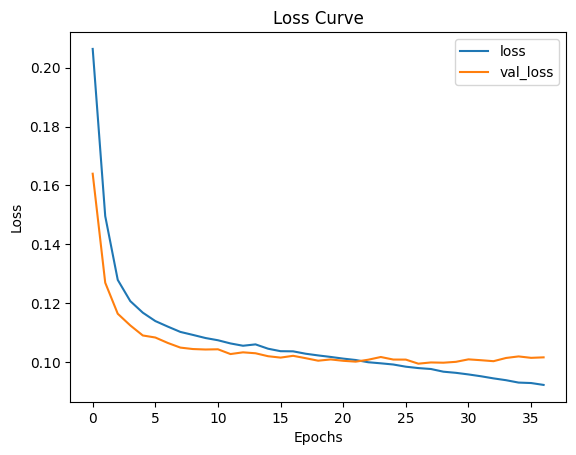

In [11]:
# Loss
import os
os.makedirs("result image",exist_ok=True)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig("result image/Loss Curve.png", dpi=600, bbox_inches='tight')
plt.show()


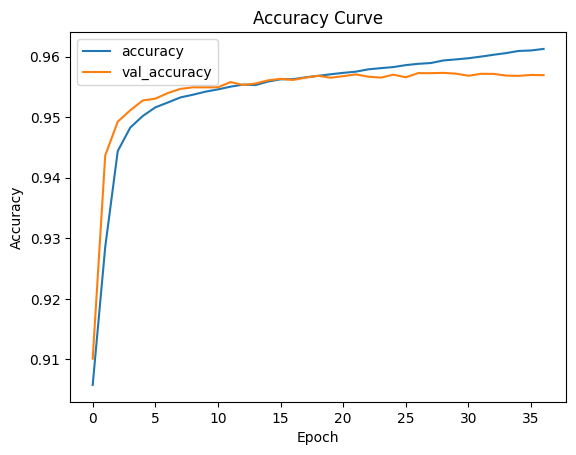

In [12]:
#Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("result image/Accuracy Curve.png", dpi=600, bbox_inches='tight')
plt.show()

### USE TEST

36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9566 - loss: 0.1011 - precision: 0.9666 - recall: 0.9478
test - loss: 0.1016, accuracy: 0.9564, precision: 0.9662, recall: 0.9478
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 973ms/step


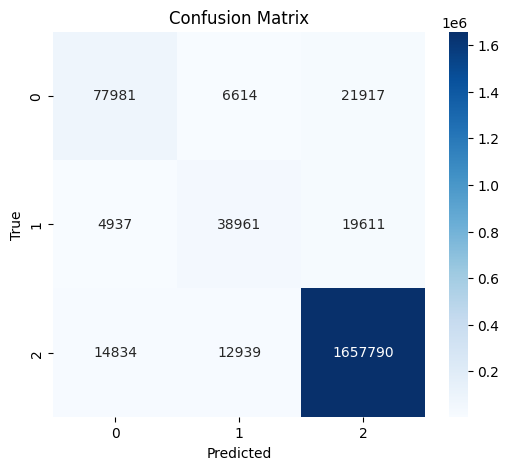

precision_overall: 0.9548
recall_overall: 0.9564
sepcificity_overall: 0.9112
F1_overall: 0.9555
accuracy: 0.9564
ROC-AUC Score: 0.9882


In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import seaborn as sns

loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"test - loss: {loss:.4f}, accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1).flatten()
y_true = np.argmax(y_test, axis=-1).flatten()

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

plt.figure(figsize=(6, 5)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2]) 
plt.xlabel('Predicted')
plt.ylabel('True') 
plt.title('Confusion Matrix') 
plt.savefig("result image/confusion_matrix.png", dpi=600, bbox_inches='tight')
plt.show()

precision_overall = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_overall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_overall = f1_score(y_true, y_pred, average='weighted', zero_division=0)


specificity = []
for i in range(len(cm)):
    TN = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    FP = np.sum(cm[:, i]) - cm[i, i]
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificity.append(spec)
specificity_overall = np.mean(specificity)



print(f"precision_overall: {precision_overall:.4f}")
print(f"recall_overall: {recall_overall:.4f}")
print(f"sepcificity_overall: {specificity_overall:.4f}")
print(f"F1_overall: {f1_overall:.4f}")
print(f"accuracy: {accuracy:.4f}")


# ROC-AUC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])  
n_classes = y_true_binarized.shape[1]


y_pred_probs_reshaped = y_pred_probs.reshape(-1, n_classes)

# Calculate ROC-AUC for each class
roc_auc = roc_auc_score(y_true_binarized, y_pred_probs_reshaped, multi_class='ovo')
print(f"ROC-AUC Score: {roc_auc:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 997ms/step
ROC-AUC Score: 0.9882


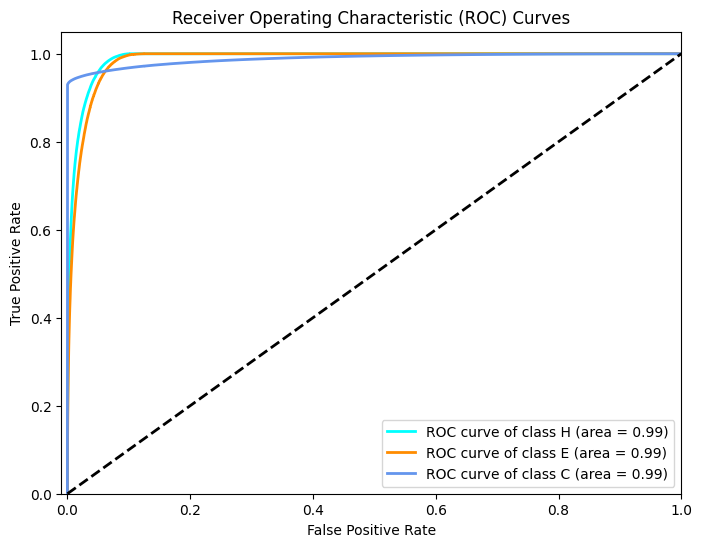

Class H:
  Precision: 0.7977
  Recall (Sensitivity): 0.7321
  Specificity: 0.9887
  F1-Score: 0.7635

Class E:
  Precision: 0.6658
  Recall (Sensitivity): 0.6135
  Specificity: 0.9891
  F1-Score: 0.6386

Class C:
  Precision: 0.9756
  Recall (Sensitivity): 0.9835
  Specificity: 0.7557
  F1-Score: 0.9795

Overall Accuracy: 0.9564


In [14]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Convert one-hot encoded labels and predictions to class labels
y_pred_probs = model.predict(X_test) 
y_pred = np.argmax(y_pred_probs, axis=-1).reshape(-1)  
y_true = np.argmax(y_test, axis=-1).reshape(-1)        

# Verify that y_pred and y_true have the same number of samples
assert y_pred.shape[0] == y_true.shape[0], "y_pred and y_true must have the same number of samples."

# Binarize the true labels for ROC-AUC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])  
n_classes = y_true_binarized.shape[1]

# Reshape y_pred_probs to match y_true
y_pred_probs_reshaped = y_pred_probs.reshape(-1, n_classes)

# Calculate ROC-AUC for each class
roc_auc = roc_auc_score(y_true_binarized, y_pred_probs_reshaped, multi_class='ovo')
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curves for each class
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs_reshaped[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['H', 'E', 'C']  

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc_dict[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig("result image/roc_curves.png", dpi=600, bbox_inches='tight') 
plt.show()

# Calculate per-class precision, recall (sensitivity), f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2], zero_division=0)

# Calculate specificity
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

specificity = {}
for i, cls in enumerate(class_names):
    TN = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    FP = np.sum(cm[:, i]) - cm[i, i]
    specificity[cls] = TN / (TN + FP) if (TN + FP) > 0 else 0.0

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print per-class metrics
for i, cls in enumerate(class_names):
    print(f"Class {cls}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall (Sensitivity): {recall[i]:.4f}")
    print(f"  Specificity: {specificity[cls]:.4f}")
    print(f"  F1-Score: {f1_score[i]:.4f}")
    print()

print(f"Overall Accuracy: {accuracy:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step   


f:\Anacoda\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lenovo\AppData\Roaming\Python\Python310\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 1632, 21))']
  warnings.warn(msg)
C:\Users\lenovo\AppData\Roaming\Python\Python310\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 1632, 21))']
  warnings.warn(msg)


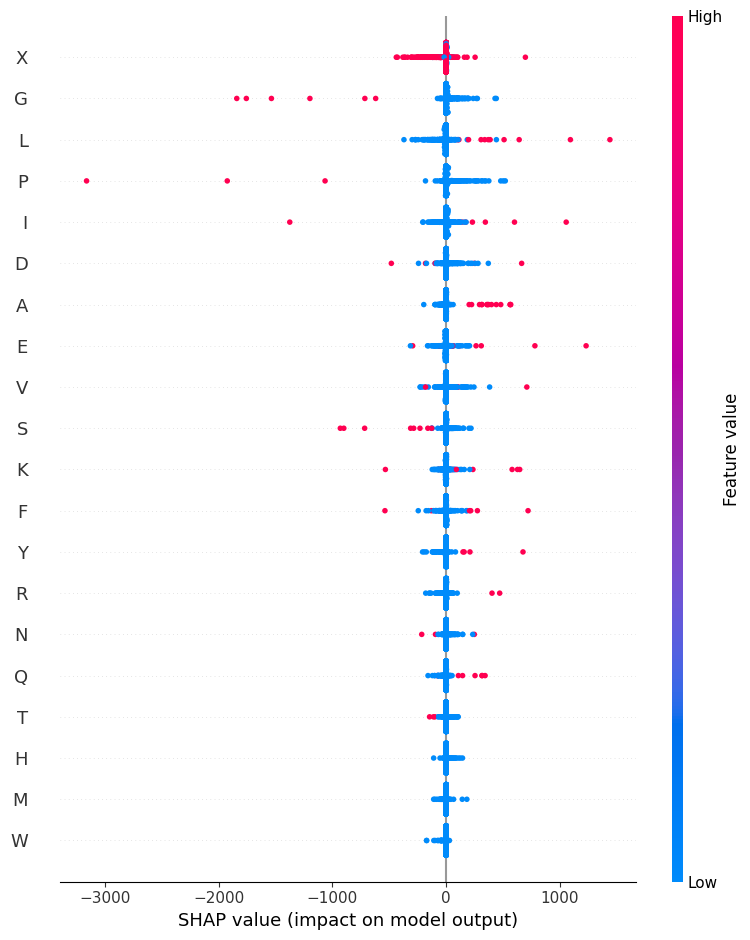

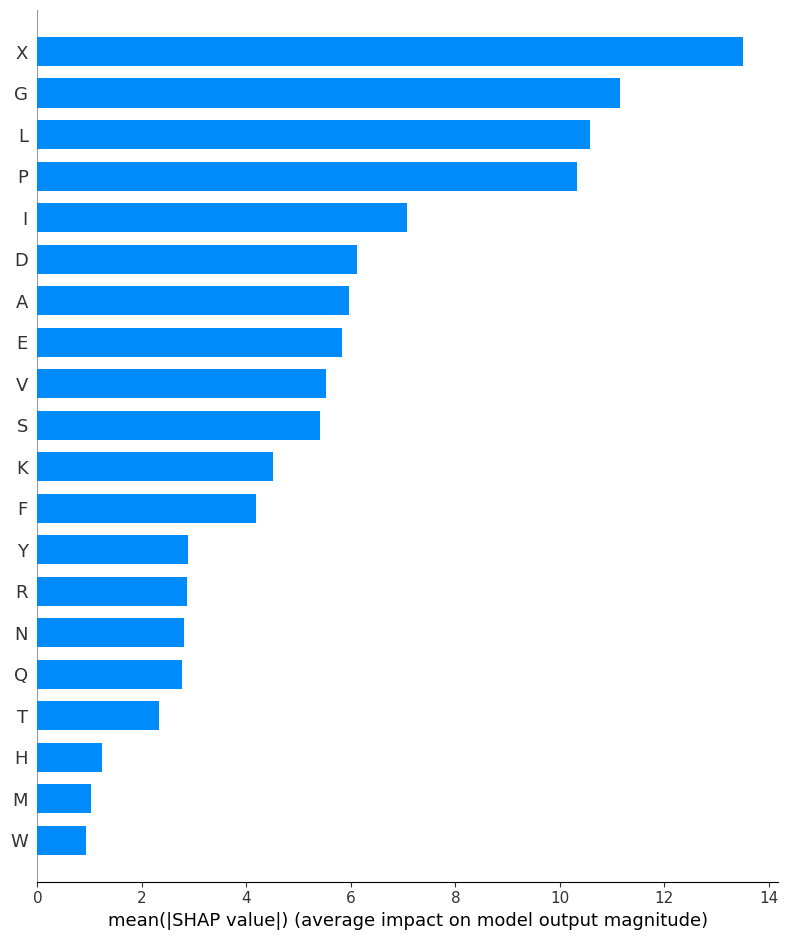

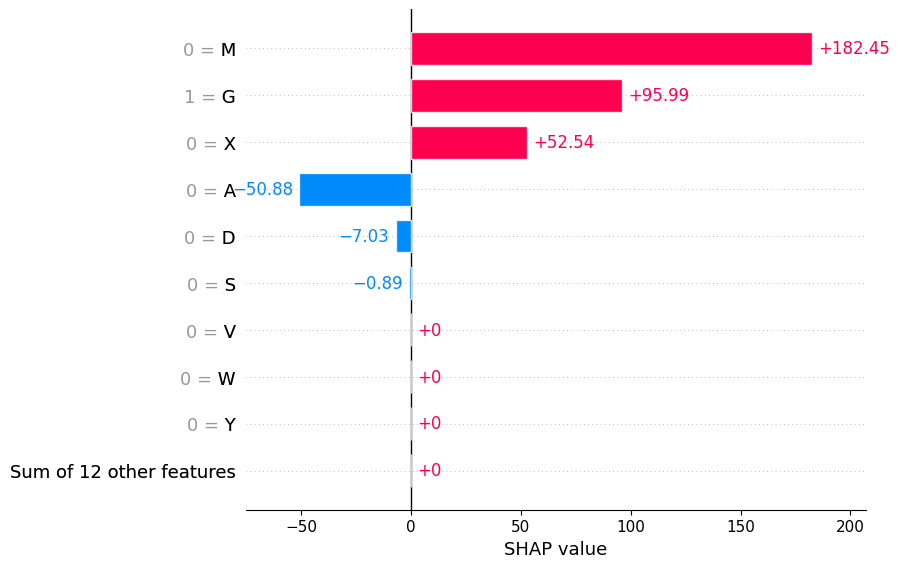

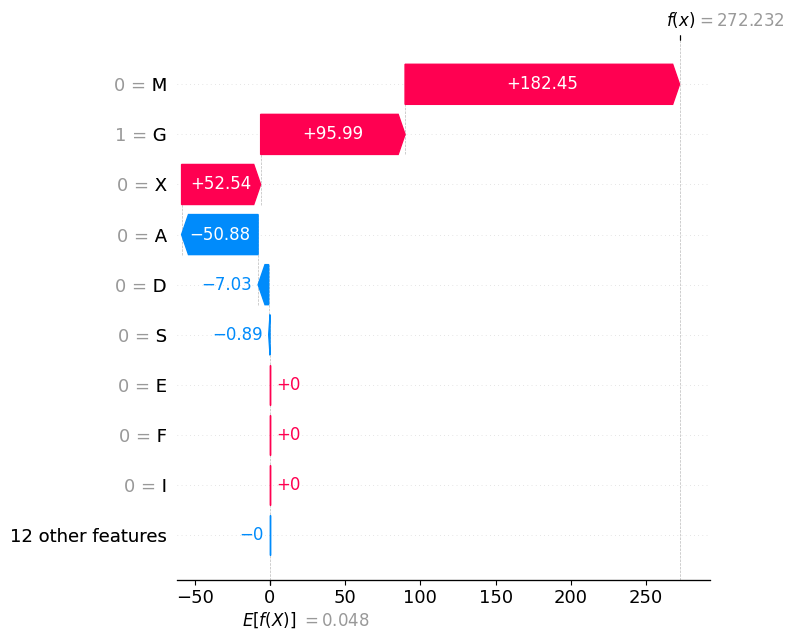

<Figure size 2000x300 with 0 Axes>

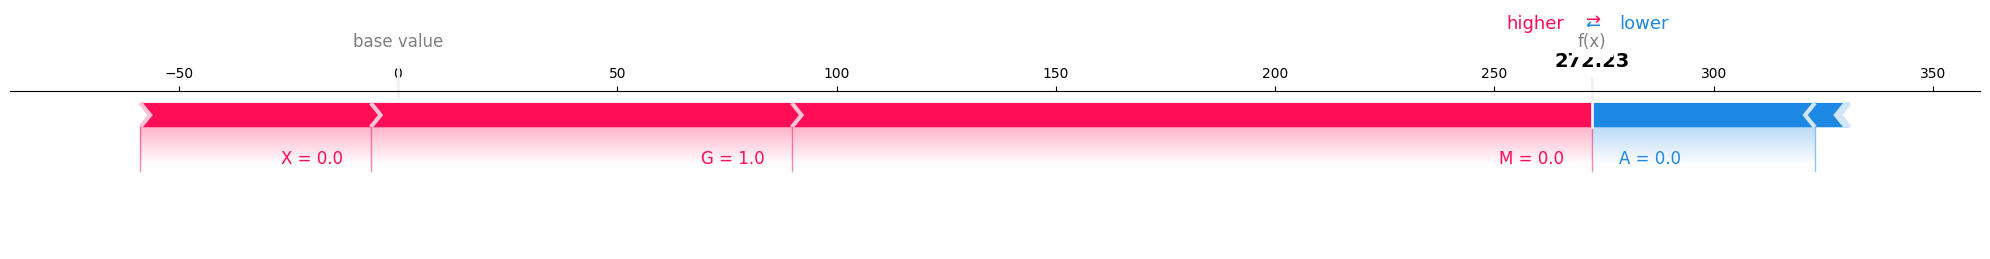

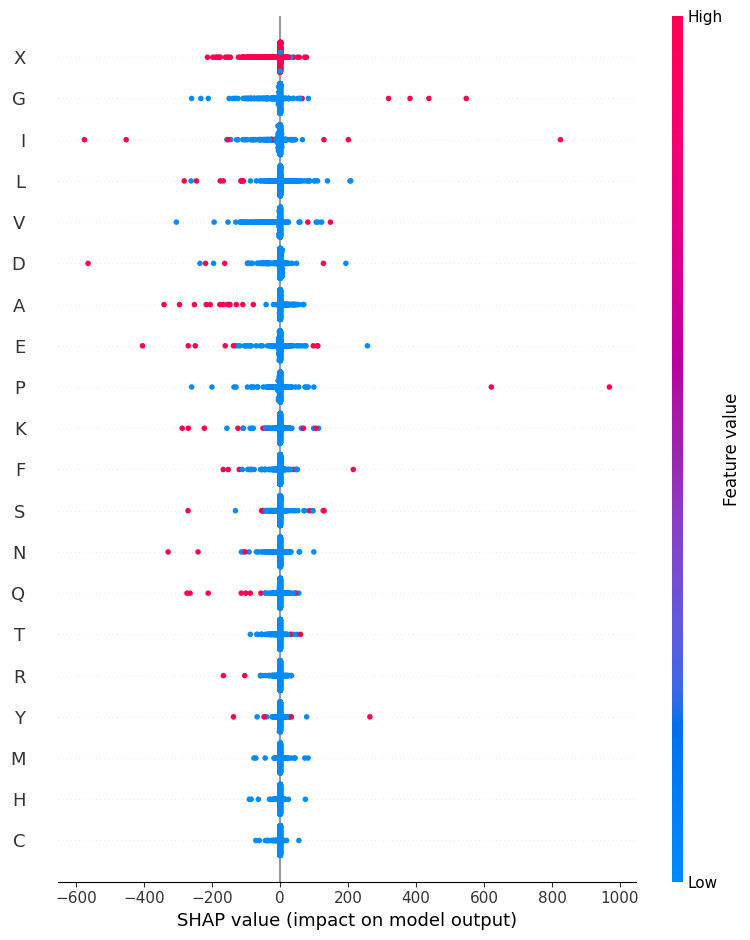

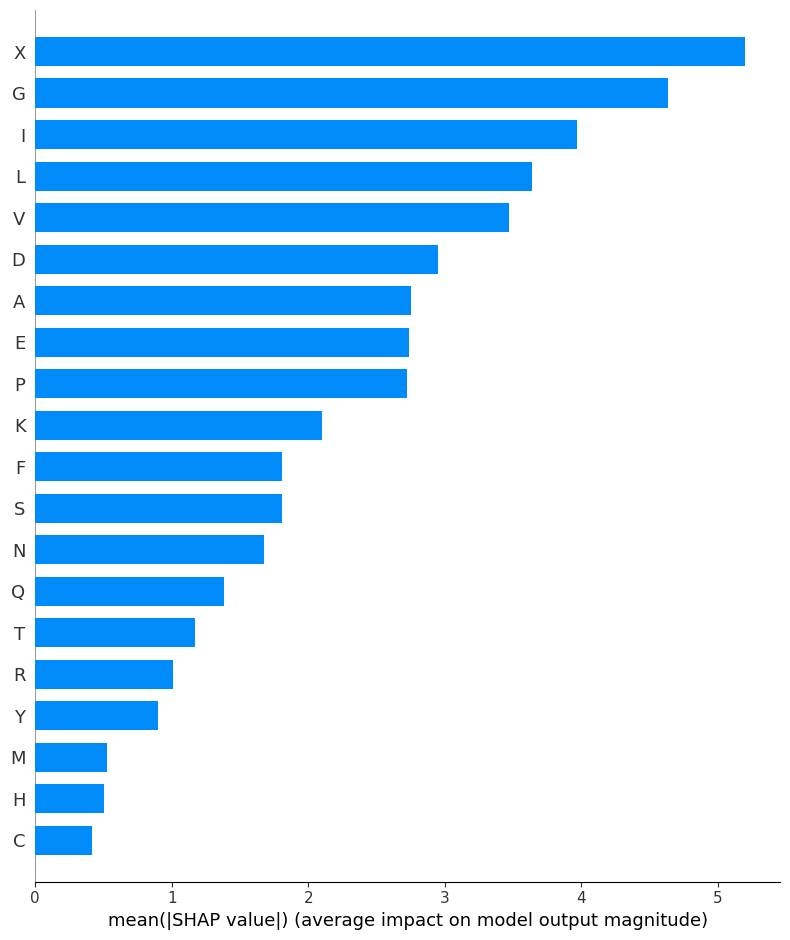

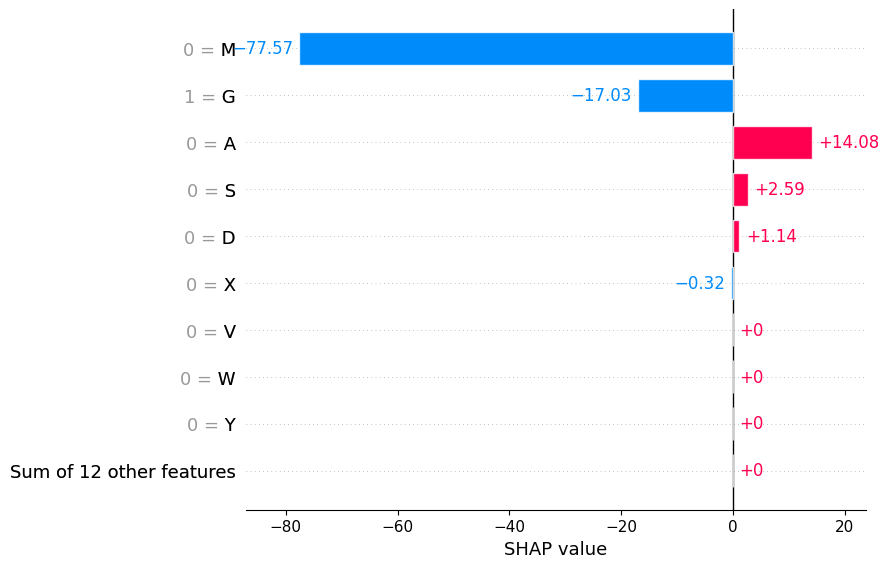

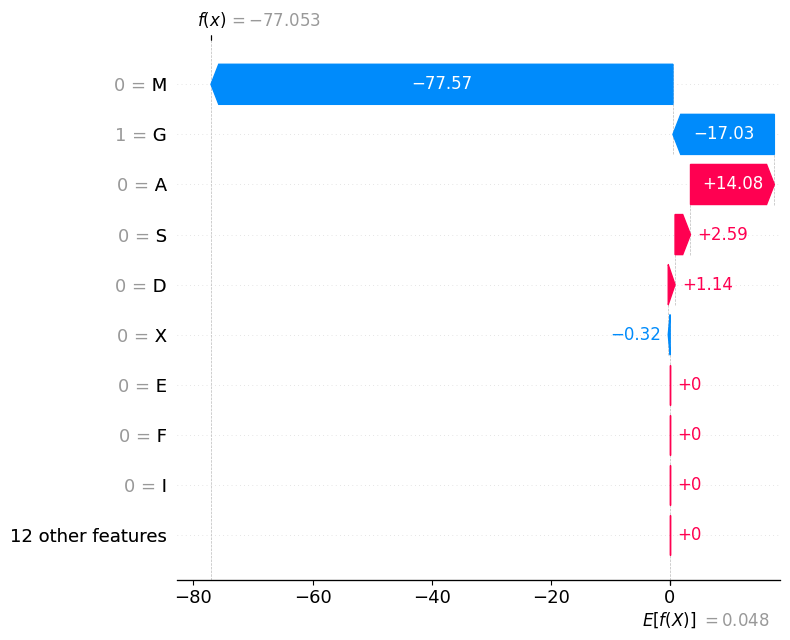

<Figure size 2000x300 with 0 Axes>

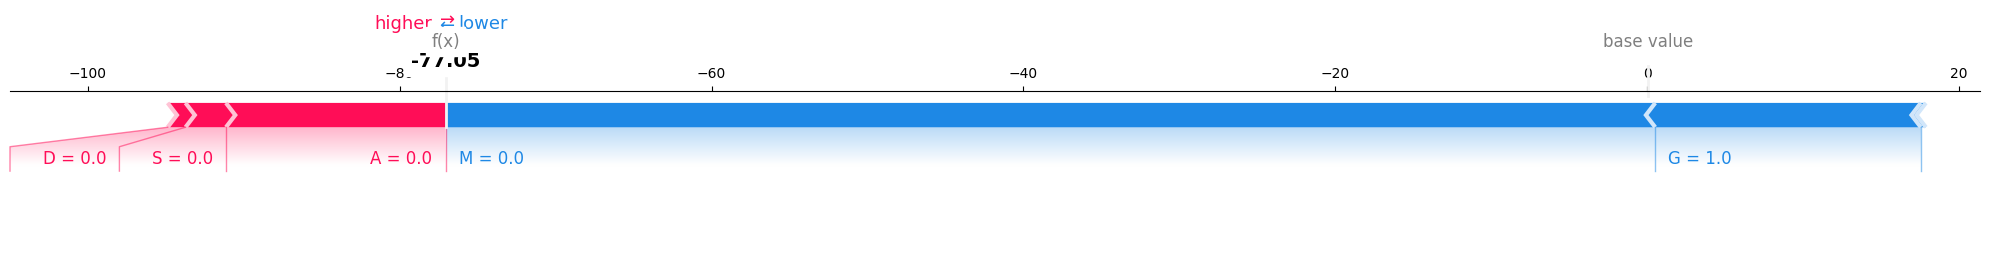

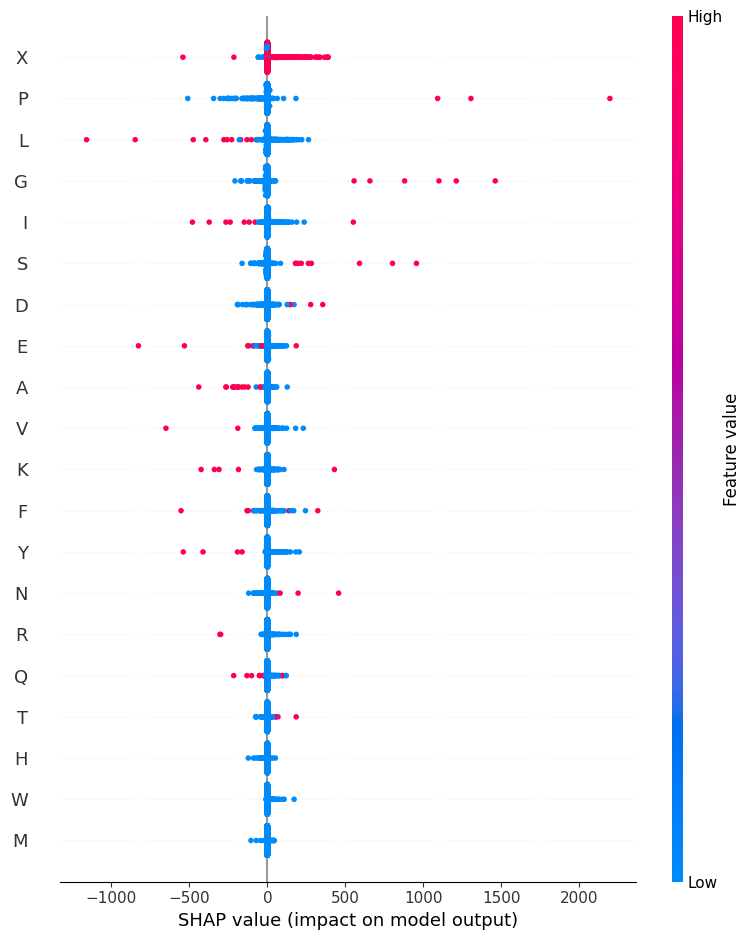

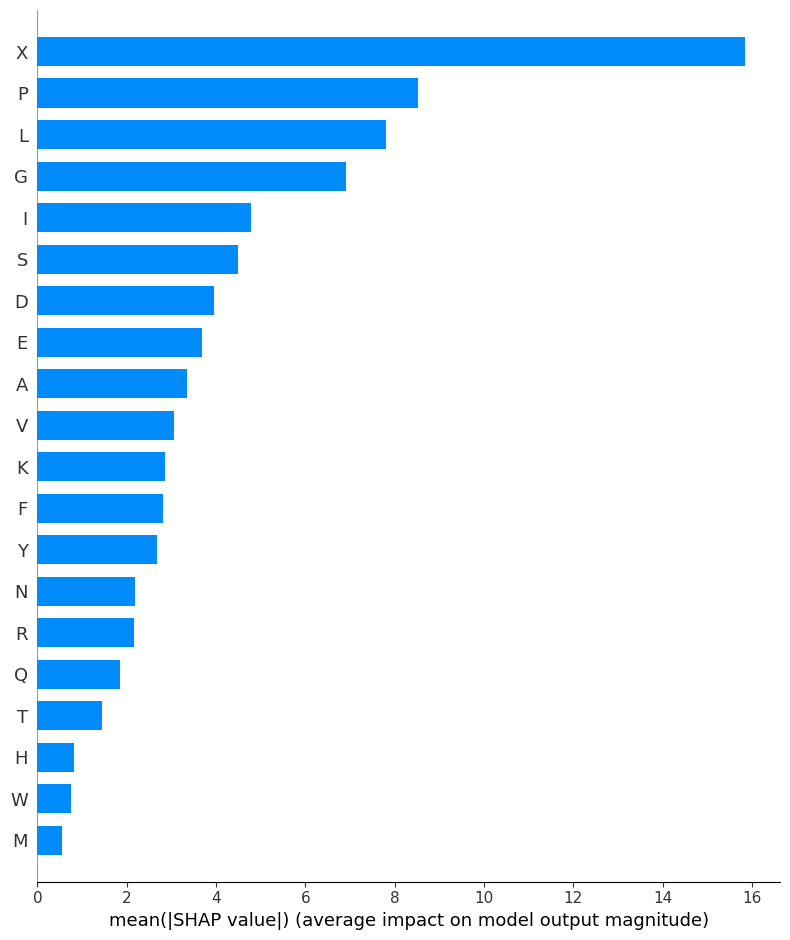

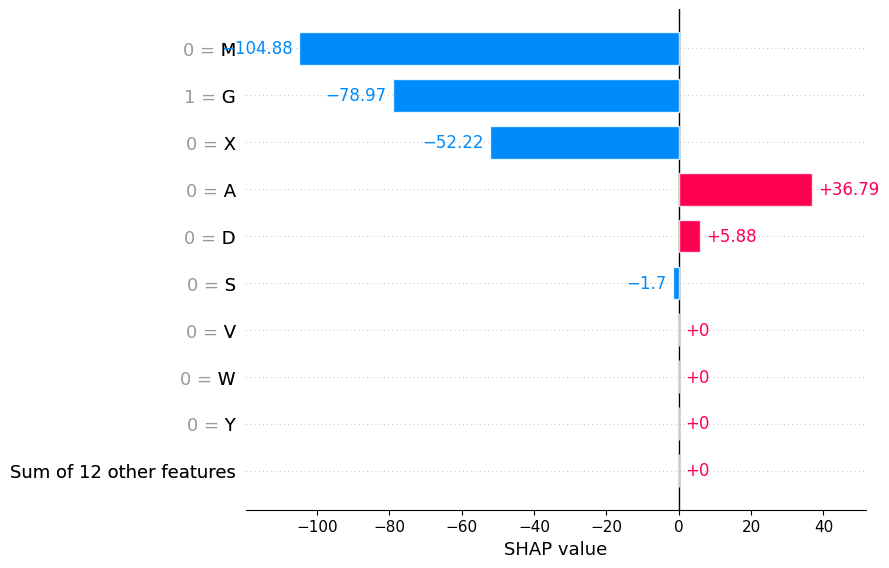

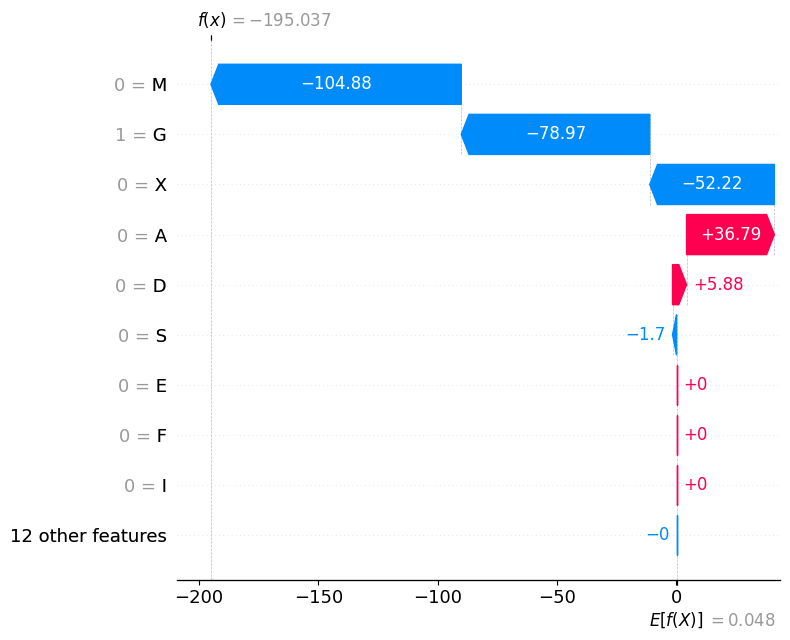

<Figure size 2000x300 with 0 Axes>

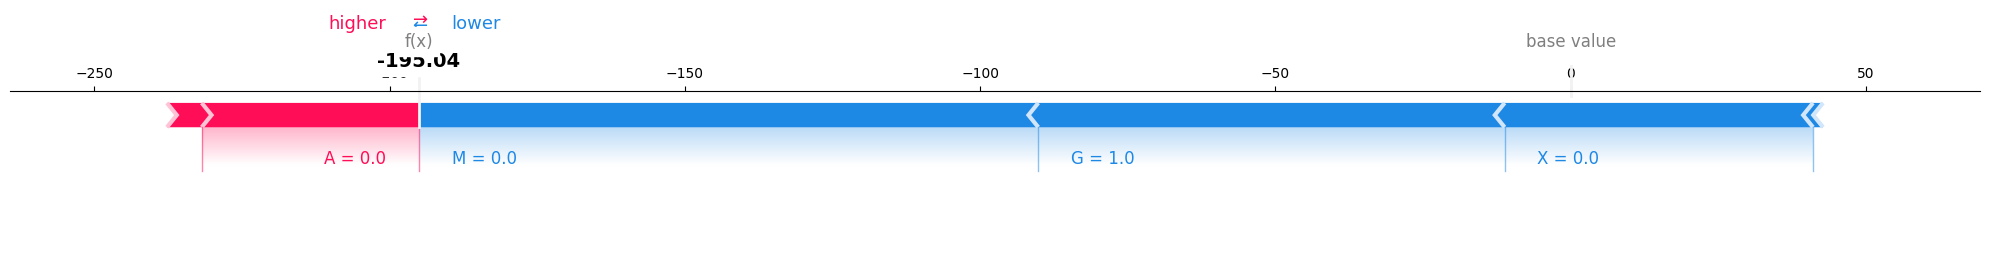

In [ ]:
os.makedirs("shap image",exist_ok=True)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D

def create_global_model_from_trained(trained_model):
    input_layer = trained_model.input
    sequence_output = trained_model.output
    global_output = GlobalAveragePooling1D()(sequence_output)
    global_model = Model(inputs=input_layer, outputs=global_output)
    return global_model

global_model = create_global_model_from_trained(model)

def get_global_prediction(model, X):
    sequence_pred = model.predict(X)
    global_pred = np.mean(sequence_pred, axis=1)
    return global_pred

global_pred = global_model.predict(X_test)


def prepare_global_labels(sequence_labels):
    global_labels = np.zeros((sequence_labels.shape[0], 3))
    for i in range(sequence_labels.shape[0]):
        valid_positions = np.where(sequence_labels[i, :, 2] != 1.0)[0]
        if len(valid_positions) > 0:
            valid_labels = sequence_labels[i, valid_positions, :]
            global_labels[i] = np.mean(valid_labels, axis=0)
        else:
            global_labels[i, 2] = 1.0
    return global_labels

y_test_global = prepare_global_labels(y_test)

import shap
background_size = 20
background_data = X_test[:background_size]
explainer = shap.GradientExplainer(global_model, background_data)
test_sample_size = 1
test_samples = X_test[:test_sample_size]
shap_values = explainer.shap_values(test_samples)

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
class_names = ['H', 'E', 'C']
sample_idx = 0
sample_seq = []
for pos in range(test_samples[sample_idx].shape[0]):
    aa_idx = np.argmax(test_samples[sample_idx, pos, :])
    if aa_idx < len(amino_acids):
        sample_seq.append(amino_acids[aa_idx])
    else:
        sample_seq.append('X')

valid_positions = [i for i, aa in enumerate(sample_seq) if aa != 'X']
valid_seq = [sample_seq[i] for i in valid_positions]

amino_acid_features = [
    'A',  # (Alanine)
    'C',  # (Cysteine)
    'D',  # (Aspartic acid)
    'E',  # (Glutamic acid)
    'F',  # (Phenylalanine)
    'G',  # (Glycine)
    'H',  # (Histidine)
    'I',  # (Isoleucine)
    'K',  # (Lysine)
    'L',  # (Leucine)
    'M',  # (Methionine)
    'N',  # (Asparagine)
    'P',  # (Proline)
    'Q',  # (Glutamine)
    'R',  # (Arginine)
    'S',  # (Serine)
    'T',  # (Threonine)
    'V',  # (Valine)
    'W',  # (Tryptophan)
    'Y',  # (Tyrosine)
    'X'   # 
]

import numpy as np

def merge_first_two_dims(arr):
    
    original_shape = arr.shape
    
    
    if len(original_shape) < 2:
        raise ValueError("The array must have at least two dimensions")
    
    new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
    
    
    return arr.reshape(new_shape)
shap_values_r = merge_first_two_dims(shap_values)
test_samples_r = merge_first_two_dims(test_samples)



shap_values_r.shape
for i, class_name in enumerate(class_names):


    # create SHAP
    shap_v = shap.Explanation(values=shap_values_r[:,:,i],
                              data=test_samples_r,
                              base_values=test_samples_r,
                              feature_names=amino_acid_features)
    shap_v.values = shap_v.values*1000000
    # dot plot
    shap.summary_plot(shap_v, plot_type='dot', show=False)
    plt.savefig(f"./shap image/{class_name}_summary_dot.jpg", dpi=600)
    plt.show()
    
    # bar plot
    shap.summary_plot(shap_v, plot_type='bar', show=False)
    plt.savefig(f"./shap image/{class_name}_summary_bar.jpg", dpi=600)
    plt.show()

    for j in range(1):
        shap.plots.bar(shap_v[j],show=False)
        plt.savefig(f"./shap image/{class_name}_bar_sample{j}.jpg", dpi=600)
        plt.show()

    

    # waterfall plot
    for sample_idx in range(min(1, len(shap_v))):
        try:
        
            sample_exp = shap.Explanation(
                values=shap_v.values[sample_idx],
                data=shap_v.data[sample_idx] if shap_v.data is not None else None,
                
                base_values=float(np.mean(shap_v.base_values[sample_idx])) if hasattr(shap_v.base_values[sample_idx], "__len__") else float(shap_v.base_values[sample_idx]),
                feature_names=shap_v.feature_names
            )
            
            plt.figure(figsize=(12, 8))
            shap.plots.waterfall(sample_exp, show=False)
            plt.tight_layout()
            plt.savefig(f"./shap image/{class_name}_waterfall_sample_{sample_idx}.jpg", dpi=600)
            plt.show()
        except Exception as e:
            print(f"Unable to class {class_name} sample {sample_idx} create waterfall plot: {str(e)}")

        
        # Force plot
    for sample_idx in range(min(1, len(shap_v))):
        try:
          
            plt.figure(figsize=(20, 3))
            
            sample_exp = shap.Explanation(
                values=shap_v.values[sample_idx],
                data=shap_v.data[sample_idx] if shap_v.data is not None else None,
                
                base_values=float(np.mean(shap_v.base_values[sample_idx])) if hasattr(shap_v.base_values[sample_idx], "__len__") else float(shap_v.base_values[sample_idx]),
                feature_names=shap_v.feature_names
            )
            
        
            shap.plots.force(sample_exp, matplotlib=True, show=False)
            plt.tight_layout()
            plt.savefig(f"./shap image/{class_name}_force_sample_{sample_idx}.jpg", dpi=600, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Unable to class {class_name} sample {sample_idx} create force plot: {str(e)}")
            
            

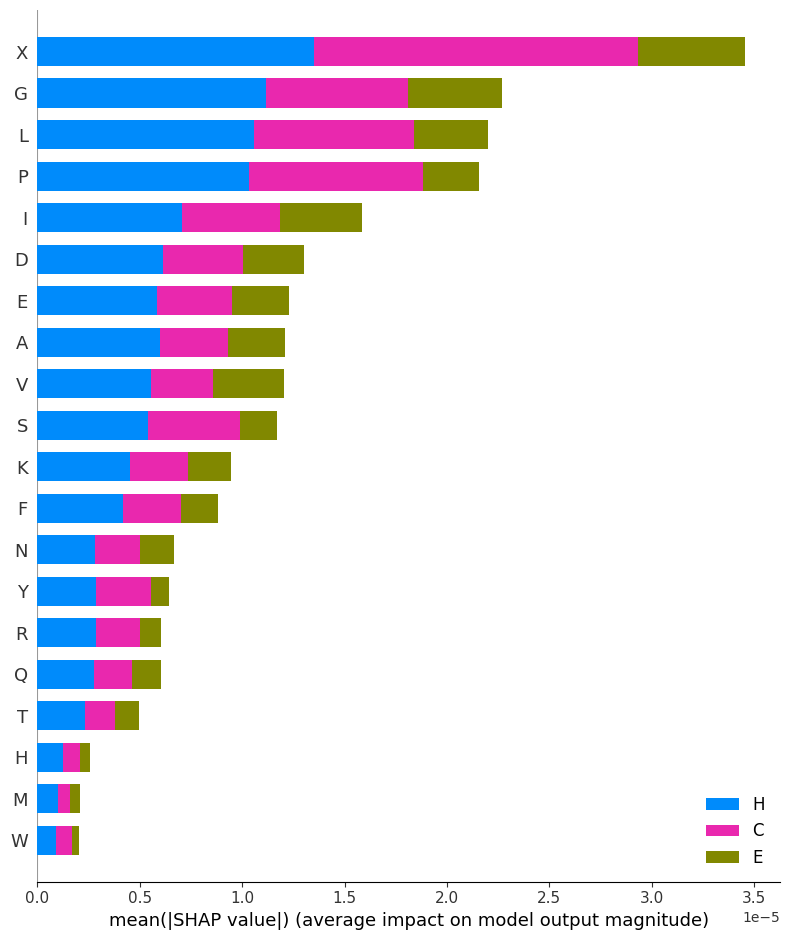

In [ ]:

shap.summary_plot([shap_values_r[:,:,i] for i,class_name in enumerate(class_names) ], plot_type='bar', show=False,feature_names=amino_acid_features,class_names=class_names)
plt.savefig(f"./shap image/{class_name}_summary_dot.jpg", dpi=600)
plt.show()